# Fast-Higashi on Dip-C Tan et al. Cell mousebrain dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_dipc_Tan_mousebrain_500k.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommend to be False
                      do_rwr=False, # For high-cov data, the differences are minor, will show later with do_rwr=True option
                      do_col=False,
                      no_col=False)


setting to gpu:7


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/1954 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 71.38 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=False) # we don't have batch_id provided so, set as False
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 1954 bad 0 total: 1954
cache file = /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl


packing sparse mtx into sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.05066675904989767
do_conv False do_rwr False do_col False
recommend_bs_cell [1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954] pinning memory
packing sparse mtx takes: 24.65 s


In [6]:
wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4 # In the original manuscript, we use this tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. Will do an ablation later
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 0.01


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
time elapsed: 14.93
finish init
Starting iteration 0

PARAFAC2 re=5.630 takes 10.9s
Starting iteration 1

PARAFAC2 re=0.341 9.96e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 11.7s
Starting iteration 2

PARAFAC2 re=0.327 7.94e-02 variation min6.2e-02 at chrom 10, max9.2e-02 at chrom 3 takes 11.9s
Starting iteration 3

PARAFAC2 re=0.315 7.21e-02 variation min5.4e-02 at chrom 10, max8.3e-02 at chrom 9 takes 12.0s
Starting iteration 4

PARAFAC2 re=0.311 2.53e-02 variation min2.1e-02 at chrom 18, max3.3e-02 at chrom 0 takes 12.0s
Starting iteration 5

PARAFAC2 re=0.309 1.08e-02 variation min5.8e-03 at chrom 18, max1.6e-02 at chrom 0 takes 12.1s
Starting iteration 6

PARAFAC2 re=0.308 5.42e-03 variation min2.1e-03 at chrom 18, max7.8e-03 at chrom 0 takes 12.2s
Starting iteration 7

PARAFAC2 re=0.308 3.16e-03 variation min1.0e-03 at chrom 18, max4.5e-03 at chrom 3 takes 12.1s
Starting iteration 8

PARAFAC2 re=0.307 2.09e-

In [7]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
# The returned embed is a dictionary that stores the embeddings after different ways of post-processing.
# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())



dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


      level_0  index                     cell       tissue treatment   age  \
0           0      0       cortex-p001-cb_001       cortex   control    P1   
1           1      1       cortex-p001-cb_002       cortex   control    P1   
2           2      2       cortex-p001-cb_003       cortex   control    P1   
3           3      3       cortex-p001-cb_004       cortex   control    P1   
4           4      4       cortex-p001-cb_005       cortex   control    P1   
...       ...    ...                      ...          ...       ...   ...   
1949     1949   2532  hippocampus-p347-cb_181  hippocampus   control  P347   
1950     1950   2535  hippocampus-p347-cb_184  hippocampus   control  P347   
1951     1951   2538  hippocampus-p347-cb_187  hippocampus   control  P347   
1952     1952   2539  hippocampus-p347-cb_188  hippocampus   control  P347   
1953     1953   2542  hippocampus-p347-cb_191  hippocampus   control  P347   

         sex    father    mother restriction enzyme  ... raw in

2022-11-26 20:38:18.229163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


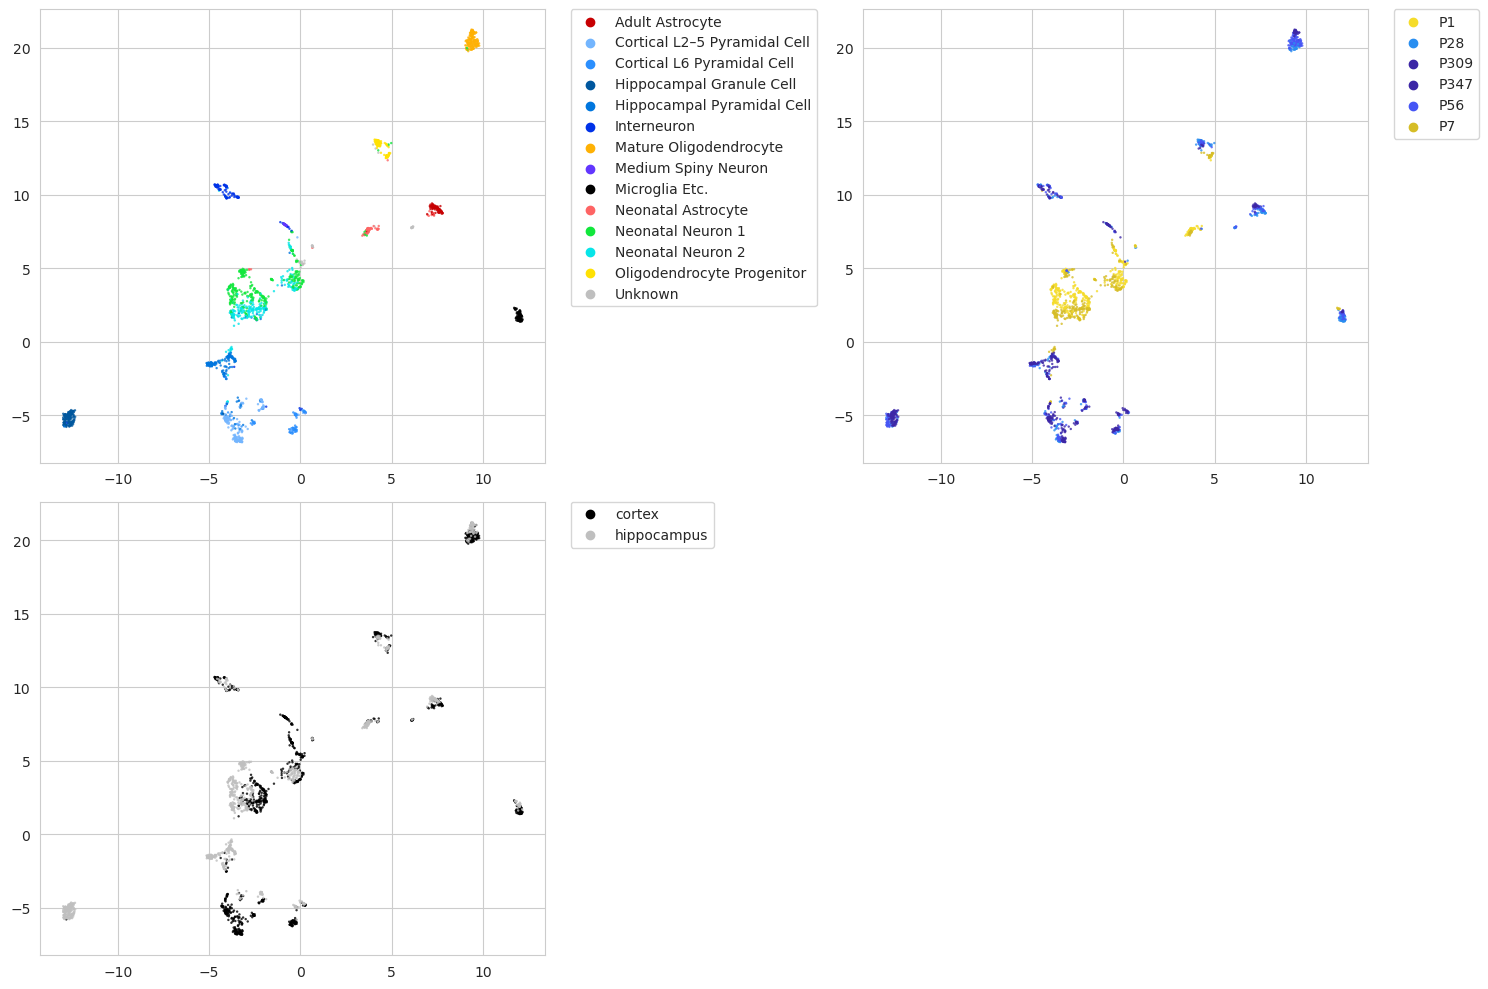

In [8]:
# Check available label information
print (wrapper.label_info)
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()




In [9]:
wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=2e-5, # OK, let's confirm my earlier claim
                  run_init=False # skip initializing the model, but continue training
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
Starting iteration 0

PARAFAC2 re=0.306 takes 12.2s
Starting iteration 1

PARAFAC2 re=0.306 1.93e-04 variation min8.7e-05 at chrom 17, max2.6e-04 at chrom 1 takes 12.1s
Starting iteration 2

PARAFAC2 re=0.306 1.80e-04 variation min7.8e-05 at chrom 17, max2.4e-04 at chrom 5 takes 12.1s
Starting iteration 3

PARAFAC2 re=0.306 1.71e-04 variation min7.8e-05 at chrom 17, max2.2e-04 at chrom 5 takes 12.1s
Starting iteration 4

PARAFAC2 re=0.306 1.47e-04 variation min7.4e-05 at chrom 17, max2.0e-04 at chrom 5 takes 12.2s
Starting iteration 5

PARAFAC2 re=0.306 1.56e-04 variation min6.0e-05 at chrom 17, max1.9e-04 at chrom 5 takes 12.1s
Starting iteration 6

PARAFAC2 re=0.306 1.43e-04 variation min7.1e-05 at chrom 17, max1.8e-04 at chrom 3 takes 12.2s
Starting iteration 7

PARAFAC2 re=0.306 1.34e-04 variation min6.3e-05 at chrom 17, max1.7e-04 at chrom 5 takes 12.1s
Starting iteration 8

PARAFAC2 re=0.306 1.31e-04 variation min6.1e-05 at chrom 17, m

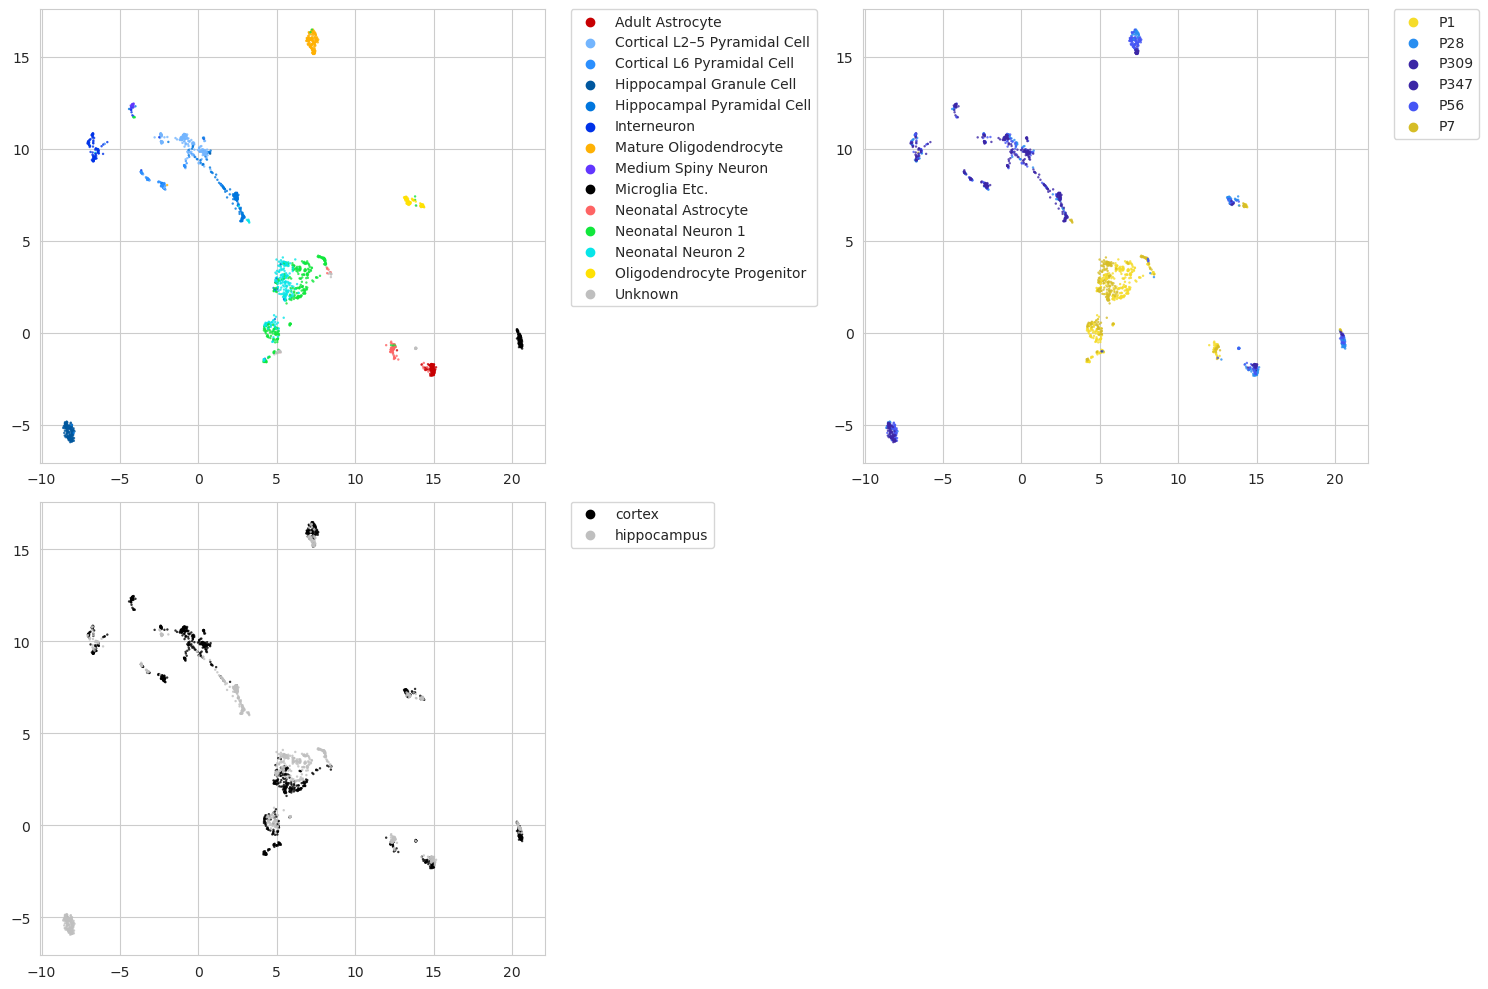

In [10]:
# For this dataset, changing tol wouldn't affect results that much.

embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()

setting to gpu:6
total number of cells that pass qc check 1954 bad 0 total: 1954
cache file = /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
loading cached input from /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.05066675904989767
do_conv False do_rwr True do_col False
recommend_bs_cell [1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954] pinning memory
dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 1.12


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5]
time elapsed: 18.18
finish init
Starting iteration 0

PARAFAC2 re=5.911 takes 11.9s
Starting iteration 1

PARAFAC2 re=0.372 9.96e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 12.6s
Starting iteration 2

PARAFAC2 re=0.360 6.61e-02 variation min4.7e-02 at chrom 7, max7.5e-02 at chrom 0 takes 12.9s
Starting iteration 3

PARAFAC2 re=0.347 7.11e-02 variation min4.9e-02 at chrom 10, max8.1e-02 at chrom 9 takes 12.9s
Starting iteration 4

PARAFAC2 re=0.343 2.28e-02 variation min1.7e-02 at chrom 10, max3.0e-02 at chrom 13 takes 13.1s
Starting iteration 5

PARAFAC2 re=0.341 9.11e-03 variation min6.2e-03 at chrom 18, max1.3e-02 at chrom 7 takes 13.0s
Starting iteration 6

PARAFAC2 re=0.341 4.63e-03 variation min2.9e-03 at chrom 18, max7.7e-03 at chrom 7 takes 13.0s
Starting iteration 7

PARAFAC2 re=0.340 2.83e-03 variation min1.6e-03 at chrom 18, max4.7e-03 at chrom 7 takes 13.0s
Starting iteration 8

PARAFAC2 re=0.340 1.92e-

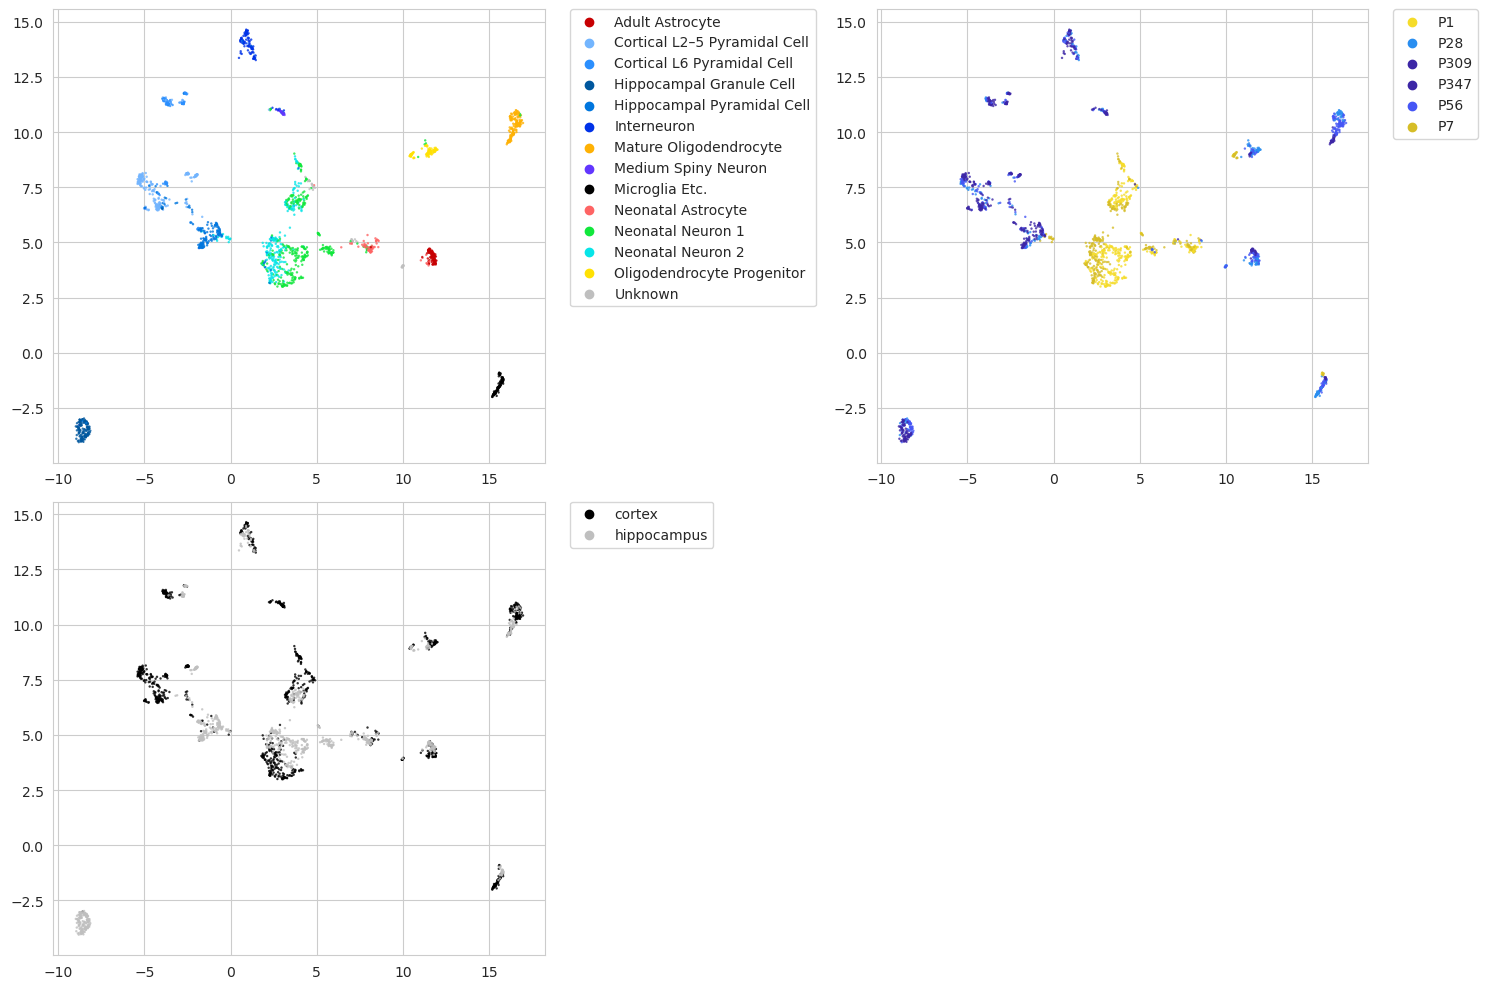

In [11]:
# Now let's validate that run with do_rwr would lead to minor change here:

wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommende to be False
                      do_rwr=True,
                      do_col=False,
                      no_col=False)
# The packed sparse tensor is cached,it will be loaded very fast
start = time.time()
wrapper.prep_dataset(batch_norm=False)

wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4 # In the original manuscript, we use this tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. Will do an ablation later
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()